In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Download real-time data for the stock (e.g., 'AAPL') for a specific date range
stock_data = yf.download('ADRO.JK', start='2024-01-01', end='2024-11-19')
real_prices = stock_data['Close'].values
print(real_prices)

[*********************100%***********************]  1 of 1 completed

[[2490.]
 [2410.]
 [2460.]
 [2440.]
 [2440.]
 [2430.]
 [2460.]
 [2450.]
 [2480.]
 [2510.]
 [2500.]
 [2490.]
 [2460.]
 [2430.]
 [2400.]
 [2350.]
 [2340.]
 [2360.]
 [2380.]
 [2400.]
 [2390.]
 [2400.]
 [2420.]
 [2420.]
 [2430.]
 [2460.]
 [2460.]
 [2470.]
 [2480.]
 [2510.]
 [2520.]
 [2430.]
 [2430.]
 [2420.]
 [2440.]
 [2420.]
 [2370.]
 [2380.]
 [2400.]
 [2420.]
 [2490.]
 [2540.]
 [2630.]
 [2670.]
 [2700.]
 [2670.]
 [2600.]
 [2670.]
 [2660.]
 [2630.]
 [2630.]
 [2650.]
 [2650.]
 [2650.]
 [2670.]
 [2740.]
 [2720.]
 [2700.]
 [2640.]
 [2690.]
 [2680.]
 [2690.]
 [2700.]
 [2810.]
 [2750.]
 [2730.]
 [2760.]
 [2750.]
 [2750.]
 [2680.]
 [2620.]
 [2600.]
 [2670.]
 [2710.]
 [2730.]
 [2730.]
 [2850.]
 [2810.]
 [2870.]
 [2950.]
 [2880.]
 [2830.]
 [2880.]
 [2880.]
 [2910.]
 [2880.]
 [2920.]
 [2870.]
 [2690.]
 [2680.]
 [2740.]
 [2770.]
 [2930.]
 [2920.]
 [2870.]
 [2850.]
 [2840.]
 [2750.]
 [2720.]
 [2790.]
 [2780.]
 [2780.]
 [2660.]
 [2730.]
 [2730.]
 [2720.]
 [2710.]
 [2750.]
 [2750.]
 [2790.]
 [2800.]
 

In [3]:
from tensorflow.keras.models import load_model

loaded_model = load_model("lstm_ADROJK_model.h5")


In [4]:
from sklearn.preprocessing import MinMaxScaler
window_size = 60 #high volatility
scaler = MinMaxScaler(feature_range=(0, 1))
# Prepare real-time stock data (use the same preprocessing as during training)
real_time_data = scaler.fit_transform(real_prices.reshape(-1, 1))  # Scale data if necessary
real_time_sequences = []  # Create sequences matching window_size

for i in range(len(real_time_data) - window_size):
    real_time_sequences.append(real_time_data[i:i + window_size])

real_time_sequences = np.array(real_time_sequences)
real_time_sequences = real_time_sequences.reshape(-1, window_size, 1)

# Predict
predicted_real_prices = loaded_model.predict(real_time_sequences)
predicted_real_prices = scaler.inverse_transform(predicted_real_prices)  # Reverse scaling


5/5 [==============================] - 3s 114ms/step


In [5]:
# Ensure the lengths of actual and predicted prices match
real_prices_trimmed = real_prices[window_size:]  # Trim to match prediction length

# MAPE Calculation
mape = np.mean(np.abs((real_prices_trimmed - predicted_real_prices.flatten()) / real_prices_trimmed)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 14.87%


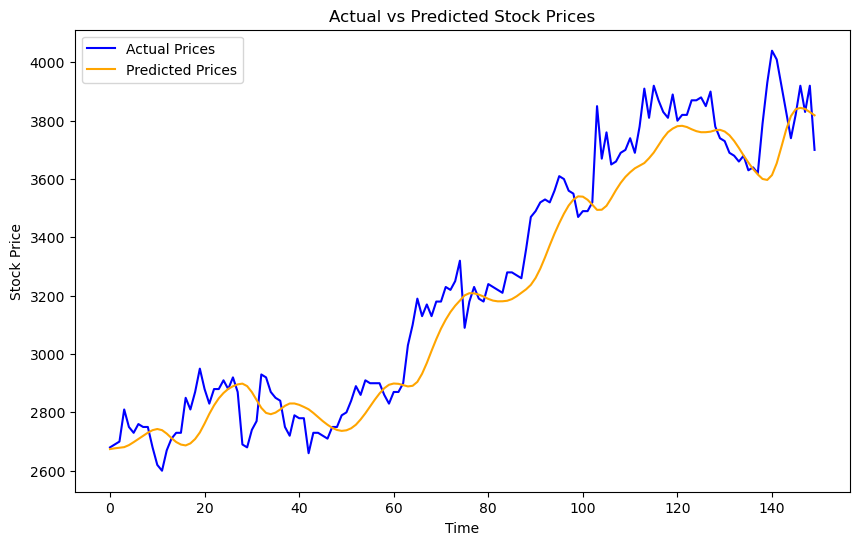

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices_trimmed, label="Actual Prices", color="blue")
plt.plot(predicted_real_prices, label="Predicted Prices", color="orange")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [7]:
n_future_days = 90

# Take the last `window_size` data points from the scaled dataset
last_sequence = real_time_data[-window_size:]  # Assuming `real_time_data` is scaled
future_predictions = []

# Iteratively predict the next day
for _ in range(n_future_days):
    # Reshape the sequence to match the input shape: (1, window_size, 1)
    last_sequence_reshaped = last_sequence.reshape(1, window_size, 1)
    
    # Predict the next day
    next_prediction = loaded_model.predict(last_sequence_reshaped)
    
    # Store the prediction
    future_predictions.append(next_prediction[0, 0])  # Extract the scalar value
    
    # Append the prediction to the sequence and remove the first value to maintain window_size
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Inverse transform the predictions to get the actual stock prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Future Predictions for the Next 3 Months:")
print(future_predictions.flatten())


1/1 [==============================] - 0s 52ms/step
Future Predictions for the Next 3 Months:
[3799.4365 3777.3496 3754.7444 3732.8691 3712.2468 3693.0278 3675.1924
 3658.6726 3643.3977 3629.305  3616.3384 3604.4407 3593.5469 3583.5825
 3574.465  3566.104  3558.4043 3551.2727 3544.619  3538.3567 3532.41
 3526.7092 3521.1956 3515.819  3510.5398 3505.3264 3500.155  3495.01
 3489.8806 3484.7632 3479.6575 3474.5657 3469.494  3464.449  3459.4402
 3454.475  3449.5632 3444.7126 3439.9314 3435.2256 3430.6006 3426.0615
 3421.6116 3417.2524 3412.9854 3408.811  3404.7283 3400.7366 3396.8323
 3393.0144 3389.2793 3385.6238 3382.0452 3378.5403 3375.1057 3371.739
 3368.4363 3365.1946 3362.0122 3358.886  3355.8142 3352.7947 3349.8254
 3346.9045 3344.0315 3341.2046 3338.422  3335.6838 3332.988  3330.3342
 3327.7217 3325.1494 3322.6172 3320.1235 3317.6687 3315.2515 3312.8708
 3310.5273 3308.2195 3305.9465 3303.7083 3301.504  3299.3333 3297.1956
 3295.089  3293.0144 3290.9707 3288.9573 3286.9736 3285.018

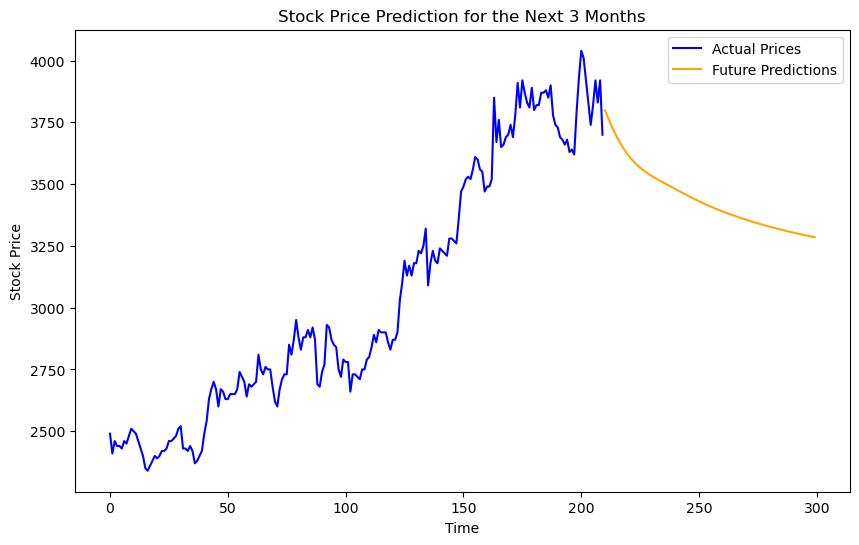

In [8]:
import matplotlib.pyplot as plt

# Create a time range for the predictions
prediction_days = np.arange(len(real_prices), len(real_prices) + n_future_days)

plt.figure(figsize=(10, 6))
plt.plot(real_prices, label="Actual Prices", color="blue")  # Historical prices
plt.plot(prediction_days, future_predictions, label="Future Predictions", color="orange")  # Predicted prices
plt.title("Stock Price Prediction for the Next 3 Months")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
